# Global AI Hub Image Processing Bootcamp

Summary: Training a CNN model to classify 10 animal types (namely collie, dolphin, elephant, fox,
moose, rabbit, sheep, squirrel, giant panda and polar bear) then manipulating test images with different light sources, testing the model prediction scores again and finally trying to revert test images with white balance algorithm. 

## 0. Imports and Environment Variables

### 0.1. Imports

- Tensorflow for importing, preprocessing, augmenting the dataset; building and testing the CNN model.
- Keras Tuner for structuring base CNN model and finding optimal hyperparameters in automation.
- Sklearn for evenly splitting train, validation and test data.
- OpenCV for reading and saving manipulated images.
- Numpy for arithmetic and tensor based operations. Required for base manipulation functions.
- os for file/folder operations.
- shutil for file/folder operations.
- datetime for basic file naming since all generated dates are unique.
- matplotlib for visualizing images
- random is not really necessary but used it to set python global random seed.

In [ ]:
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import random
import os
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

### 0.2. Environment variables. 

- IMAGE_SIZE: Model input width and height.
- BATCH_SIZE: Dataset batch size.
- SEED: For reproducibility.
- AUTOTUNE: Used in TensorFlow data pipeline.
- EPOCHS: Max epochs model can be trained.
- NUM_CLASS: Total number of classes. Used in model final dense layer.
- DATE: For generating unique file names and timestamping.

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
SEED = 7
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 50
NUM_CLASS = 10
DATE = datetime.now()

### 0.3. Setting up global seeds 

For libraries using random numbers. Added for reproducibility.

In [3]:
# Set seed globally 
tf.keras.utils.set_random_seed(SEED)  
np.random.seed(SEED)                 
random.seed(SEED)   

## 1. Using the Dataset

### 1.1. Splitting From Original

Split first 650 items from base dataset. Create directories if not present. To achieve equally distributed labels, created train, val and test sub-datasets by sckitlearn train_test_split. Images from all classes selected randomly and copied to their respective split folders.

First up, first 650 images splitted 70% train and 30% rest. Then validation and test images split from rest of the images.

In [4]:
def split_dataset(source_dir, target_dir, class_list, num_samples=650, 
                  train_ratio=0.7, val_ratio=0.15):
    """
    Split the first `num_samples` images from specified class folders into train, 
    val, and test datasets.

    Args:
        source_dir (str): Path to the source directory containing class folders.
        target_dir (str): Path to the target directory to store splits.
        class_list (list): List of class folder names to process.
        num_samples (int): Number of images to select per class.
        train_ratio (float): Proportion of images for training.
        val_ratio (float): Proportion of images for validation.
    """
    # Ensure the target directories exist
    os.makedirs(target_dir, exist_ok=True)
    train_dir = os.path.join(target_dir, 'train')
    val_dir = os.path.join(target_dir, 'val')
    test_dir = os.path.join(target_dir, 'test')
    for d in [train_dir, val_dir, test_dir]:
        os.makedirs(d, exist_ok=True)

    for class_name in class_list:
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            print(f"Warning: Class folder '{class_name}' not found in source directory.")
            continue

        # Get the first `num_samples` images for the current class
        all_images = sorted(os.listdir(class_path))[:num_samples]

        # Split into train, val, and test
        train_files, temp_files = train_test_split(all_images, train_size=train_ratio, random_state=7)
        val_files, test_files = train_test_split(temp_files, test_size=val_ratio / (1 - train_ratio), random_state=7)

        # Define target class directories
        for subset, subset_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            subset_class_dir = os.path.join(target_dir, subset, class_name)
            os.makedirs(subset_class_dir, exist_ok=True)
            for file_name in subset_files:
                src_file = os.path.join(class_path, file_name)
                dst_file = os.path.join(subset_class_dir, file_name)
                shutil.copy(src_file, dst_file)

        print(f"Processed class '{class_name}' with {len(all_images)} images.")

# Specify the desired classes
class_folders = [
    "collie", "dolphin", "elephant", "fox",
    "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"
]


source_directory = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
target_directory = "kaggle/working/AwA2-10-650-split"

split_dataset(source_directory, target_directory, class_list=class_folders)


Processed class 'collie' with 650 images.
Processed class 'dolphin' with 650 images.
Processed class 'elephant' with 650 images.
Processed class 'fox' with 650 images.
Processed class 'moose' with 650 images.
Processed class 'rabbit' with 650 images.
Processed class 'sheep' with 650 images.
Processed class 'squirrel' with 650 images.
Processed class 'giant+panda' with 650 images.
Processed class 'polar+bear' with 650 images.


### 1.2. Ensuring Homogeneous Label Distribution

Count all images under train, validation and test folders to ensure images and labels distributed equally. Imbalanced datasets cause bias in predictions. If a class is under represented in a dataset, effected class will be less likely to predicted correctly. 

As can be seen, in train set there are 454 images in all classes, this number is 98 in both in validation and test subsets.

In [5]:
# Count for label distribution

def count_labels_in_directory(directory_path):
    class_counts = {}
    for class_name in os.listdir(directory_path):
        class_dir = os.path.join(directory_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print("Train class counts:\n", count_labels_in_directory("./AwA2-10-650-split/train"), "\n")
    
print("Validation class counts:\n", count_labels_in_directory("./AwA2-10-650-split/val"), "\n")
    
print("Test class counts:\n", count_labels_in_directory("./AwA2-10-650-split/test"), "\n")

Train class counts:
 {'giant+panda': 454, 'elephant': 454, 'dolphin': 454, 'sheep': 454, 'moose': 454, 'polar+bear': 454, 'squirrel': 454, 'rabbit': 454, 'fox': 454, 'collie': 454} 

Validation class counts:
 {'giant+panda': 98, 'elephant': 98, 'dolphin': 98, 'sheep': 98, 'moose': 98, 'polar+bear': 98, 'squirrel': 98, 'rabbit': 98, 'fox': 98, 'collie': 98} 

Test class counts:
 {'giant+panda': 98, 'elephant': 98, 'dolphin': 98, 'sheep': 98, 'moose': 98, 'polar+bear': 98, 'squirrel': 98, 'rabbit': 98, 'fox': 98, 'collie': 98} 



## 2. Preprocessing the Dataset

### 2.1. Initial Import

Used `tf.keras.utils.image_dataset_from_directory` function to import datasets. Train, validation and test datasets are imported seperately to achieve random non-intersected subsetting along with equally distributed data samples. 

_Note: I have made a grave mistake previously by letting TensorFlow handle randomness with multiple `image_dataset_from_directory` but in the end it either caused intersecting data samples among the different subsets (namely train, test and val) or if not shuffled, test dataset would only have samples of one or two classes depending on train-test split ratio._

In all sub-datasets image size is (224, 224), labels are inferred from folder names alphabetically and labelled with label encoding [0-9]. Imported as RGB so final image shape is (224, 224, 3). Batched 32 and seeded with global seed for reproducibility.

Class names are stored here too because later, data will be prefetched and original labels will be lost after turning dataset to type PrefetchDataset.

In [97]:
# Generate batched dataset, apply resizing and label encoding
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "./AwA2-10-650-split/train",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int",
    labels="inferred",
    color_mode="rgb",
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "./AwA2-10-650-split/val",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int",
    labels="inferred",
    color_mode="rgb",
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "./AwA2-10-650-split/test",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int",
    labels="inferred",
    color_mode="rgb",
    shuffle=True
)

class_names = train_dataset.class_names

Found 4540 files belonging to 10 classes.
Found 980 files belonging to 10 classes.
Found 980 files belonging to 10 classes.


Extracted class names can be seen here.

In [98]:
print(class_names)

['collie', 'dolphin', 'elephant', 'fox', 'giant+panda', 'moose', 'polar+bear', 'rabbit', 'sheep', 'squirrel']


A helper function to show samples from any dataset containing an image.

In below picture, images can be seen from first batch of the train dataset.

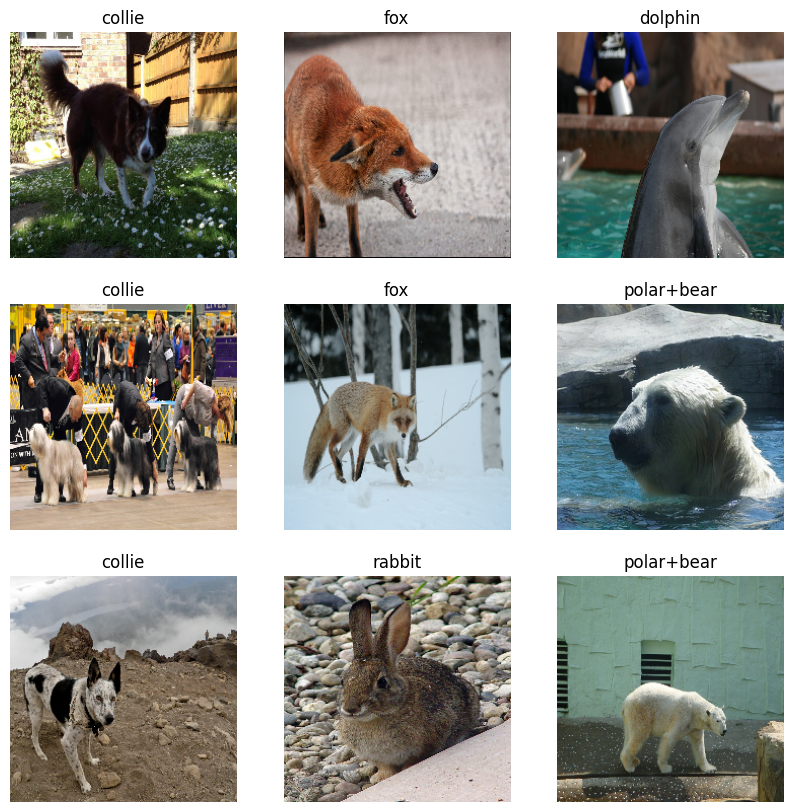

In [99]:
def show_data_examples(dataset=None, take=1, normalized=False):
    plt.figure(figsize=(10, 10))
    images, labels = next(iter(dataset.take(take)))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if not normalized:
            plt.imshow(images[i].numpy().astype("uint8"))
        else:
            plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

show_data_examples(train_dataset)

### 2.2. Data Augmentation

Data augmentation is applied to the train dataset using Keras API's augmentation layers in order to make CNN model more resilient to brighter environments or animals in different angles. Random zoom is slightly applied (5-10%) because some of the images were far from animal. Most of the images have large unnecessary background spaces. Zooming can help preventing model learn background features.

Amount of parallel calls to dataset is autotuned by TensorFlow according to the machine trained on.

In [100]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=SEED),
    tf.keras.layers.RandomRotation(0.1, seed=SEED),
    tf.keras.layers.RandomBrightness(0.2, seed=SEED),
    tf.keras.layers.RandomZoom(width_factor=(-0.05, -0.1), height_factor=(-0.05, -0.1), seed=SEED)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

Random samples from augmented dataset can be seen below. Especially rotations is visible. Other manipulations are not visible without having a comparable base image.

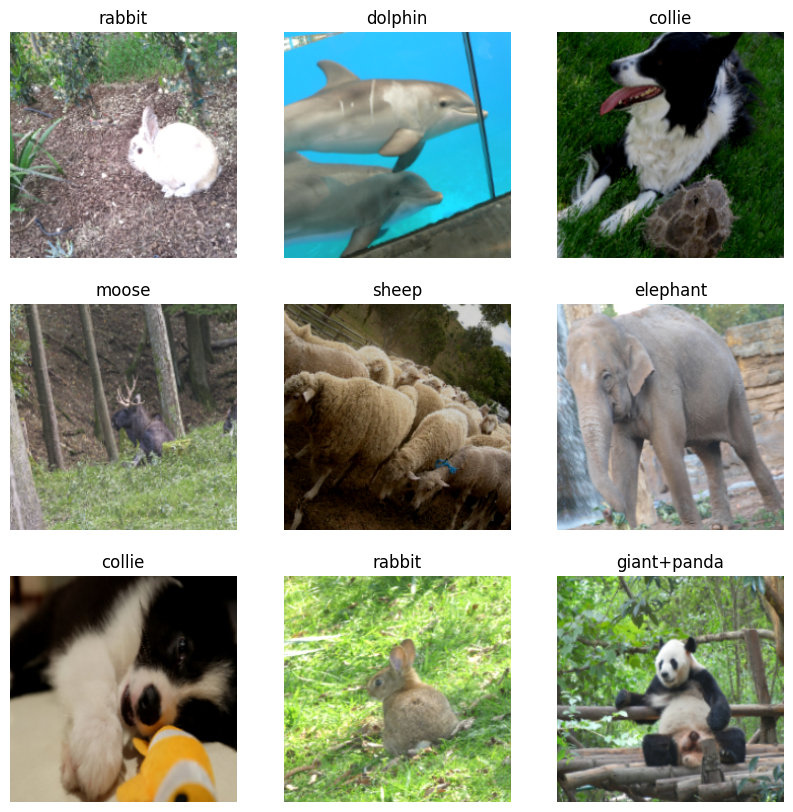

In [103]:
show_data_examples(train_dataset)

### 2.3. Normalization

Since the dataset is imported as TensorFlow dataset, normalization is done with Rescaling layer. All sub-sets are normalized. Normally I would implement rescaling inside the model after input layer but then image manipulation functions would require normalized inputs too. So instead embedding rescaling layer into model, made it seperated like a helper function that can be later utilized. If needed, rescaling layer can be added without distrupting model capabilities.

In [104]:
# Normalize datasets
normalization = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization(x), y))

### 2.4. Improving Dataset Performance

Cache and prefetch train and validation datasets so a new batch would be ready to be fed to the model after previous one is consumed. Buffer size is decided by TensorFlow here too according to the machine specs.

In [105]:
# Optimize dataset performance
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## 3. CNN Model Design

### 3.1. Baby Steps - Automated Algorithmic Search

A function in order Keras Tuner to experiment and decide optimal hyperparameters. Not all hyperparameters are decided by tuner. Instead developer decides which hyperparameters should be tested. 

Tried many configurations before this (below) particular model architecture. Staring with one convolution layer, one max pooling layer and dense layer with 10 units and went all the way up many convolution layers with incresing kernel numbers for creating many different feature maps. 


#### 3.1.1. Model Mold

Below model consists of 3 main pieces: Input, convolution layer(s) and dense layers.
- **Input** layer is (224, 224, 3) shape. 224 width/height and is a good balance between performance and accuracy from personal experiences.
- **Convolution** layer depth is decided by Keras Tuner.
- Used `Conv2D` since input is image. Convolution layers can range from 1 to 6. Incresed kernel size with each convolution layer by twice. Calculated as `32 * (pow(2, i))` thus creating convolutional layers having more feature maps for more abstract features such as shapes and whole objects. Deeper the neural network, has more capacity to generalize and extract information. But not always deepest means the best. Layer count has diminishing returns like overfitting.
- Being said, to overcome overfitting **`BatchNormalization`** is applied. While experimenting observed that, models without batch normalization tend to overfit quicker than their with normalization layer added counterpart. Also observed, with batch normalization both train and validation accuracy is went little lower. Without, both accuracy values were 5 to 10% higher but had worse test accuracy. Tried to find a middle ground without hurting accuracy by normalizing so much to overcome overfitting.
- **Kernel size** of (3, 3) worked the best. Some researches found having bigger kernel sizes on earlier layers can help generalizing the data more. In this case opposite happened therefore all kernel sizes are kept (3, 3).
- **Padding** is set to same to keep lowering feature map size gradually while increasing the depth.
- **Activation function** is not set in order to be able to add Batch Norm layers.
- Later **ReLU** activation function used for convolution layer(s). ReLU is a very simple and fast activation function and used widely. Observed that shortens the training time.
- Finally added **`MaxPooling2D`** to reduce dimensionality (width/height-wise) and extract dominant featues.
- Used **`GlobalAveragePooling2D`** instead `Flatten` layer for better generalization performance. Apparently Flatten layer causes some features seperated and leads to loss of information.
- Amount of neurons of the first **dense layer** that classifies from extracted knowledge by convolution blocks decided by Keras Tuner.
- `Dense` layer contains fully connected neurons. Amount of neuron units has a direct effect on model capacity/ability to learn/prediction accuracy. But also has diminishing returns like convolution depth.
- Amount of units are ranging from 32 to 1024. Tuner is testing values between 32 and 1024 (inclusive) with steps of 32. Then another batch normalization layer is followed for mitigating overfitting.
- A **dropout** layer used for further generalization performance. On previous tests values ranging from 0.1 to 0.5 used. Much of the results showed 0.2 is a good performer. But in my humble opinion, in a dense layer, you either should rely or not to a neuron. Dropout layer randomly (with 50% chance in this scenario) deactivates a neuron while training to regularize dense layer, so in all those neurons not only couple of them be dominant.
- Final layer is another dense layer with 10 units. Every single unit corresponds to one class output. Starting from 0 to 9 (because of label encoding) for the dataset's total predictable class count.
- Model-wise explanation ends here. Next is compiling the model before tuning.

#### 3.1.2. Compiling Model

- In order to compile a model 3 core elements needed: Optimizer for gradient descent, a loss function to calculate difference between ground truth and predicted output and a metric to improve with training.
- An **optimizer** can have many different hyperparameters but most important one is learning rate.
- **Learning rate** is basically the step size of the gradient descent. Too big, you overshoot from the target. too low, you never reach the ideal. Different optimizers have different default learning rates. Experimenting is the essence to find optimal learning rate which is the essence of optimal accuracy and train time.
- Tuner picks either of 1e-3, 5e-4, 1e-4 and chooses the one yields best result.
- Due to multiclass classification and label encoding **loss function** was chosen `SparseCategoricalCrossentropy`.
- From same reasons train **metric** was chosen `SparseCategoricalAccuracy`

In [13]:
def build_model(hp):

    model = tf.keras.models.Sequential(name="super_awesome_animal_classifier")

    model.add(tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

    hp_conv_layer_count = hp.Int("conv_layers", min_value=1, max_value=6, step=1)
    for i in range(hp_conv_layer_count):
        model.add(tf.keras.layers.Conv2D(int(32 * (2**i)), (3,3), padding='same', activation=None))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPooling2D((2,2)))

    # Pooling instead of flattening the output for better generalization
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Dense layers
    hp_units = hp.Int("units", min_value=32, max_value=1024, step=32)
    model.add(tf.keras.layers.Dense(hp_units, activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(NUM_CLASS, activation="softmax", name="output"))

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    )

    return model

### 3.2. Hyperband Tuner

[Hyperband](https://keras.io/keras_tuner/api/tuners/hyperband/) algorithm implemented by [Keras Tuner](https://keras.io/keras_tuner/) used to find optimal hyperparameters giving the highest validation acuuracy. Validation accuracy was chosen insted of validation loss because dataset is balanced. In case of an imbalancement among classes validation loss could be chosen for searching. Search i conducted for maximum of 10 epochs in order to observe many results in a short period of time.

In [14]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3
    )

### 3.3. Tuning Callbacks

Some callbacks were added in order to monitor some metrics while tuning.

- **Early Stopping** with patience of 5: Monitor validation loss and if for 5 epochs has not decreased stop fitting process.
- **Reduce Learning Rate** by half if validation loss has not decreased in last 2 epochs until learning rate reaches 1e-6.

In [15]:
tuner_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]

### 3.4. Searching For Optimal

Initialized the search with train dataset for maximum of 10 epochs. To monitor, validation dataset and callbacks are added too.

After 30 trials, maximum of 57% validation accuracy achieved.

In [17]:
tuner.search(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=tuner_callbacks
    )

Trial 30 Complete [00h 00m 32s]
val_accuracy: 0.30918368697166443

Best val_accuracy So Far: 0.5744897723197937
Total elapsed time: 00h 17m 22s


In order to get the best hyperparameter values `tuner.get_best_hyperparameters()` function used.

In [18]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is {best_hps.get('units')},
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}
and the optimal convolutional layer count is {best_hps.get('conv_layers')}.
""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 576,
the optimal learning rate for the optimizer is 0.0005
and the optimal convolutional layer count is 6.



Then with `tuner.hypermodel.build(best_hps)` CNN model has built. Model architecture can be seen below.

In [19]:
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "super_awesome_animal_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 14, 14, 512)         │              

 Total params: 6,894,730 (26.30 MB)

 Trainable params: 6,889,546 (26.28 MB)

 Non-trainable params: 5,184 (20.25 KB)

### 3.5. Actual Training

With model built, actual training phase can begin. Callbacks are used in this phase too.

**Early Stopping**: Monitor validation loss, if no decrease happens in the last 10 epochs stop training to not waste system resources. Because model probably started to overfit at that point. Restore the weights after training ends with lowest validation loss.

**Reduce Learning Rate**: If no decrease happens in last 2 epochs, decrease learning rate by half to prevent overshoot until learning rate reaches 1e-6. Alternatively custom callbacks with gradual learning rate decreasing can be written but since I can't predict the gradient don't wanted to decrease by hand. Instead monitored the loss to catch descent fluctuations. Also log to console with verbose.

**Model Checkpoint**: To save the model with lowest validation loss (Just in case)

**CSV Logger**: Log model history as CSV file. (Personal preference. Like to store data about models.)

In [29]:
# Train Callbacks
checkpoint_name = "Epoch{epoch:03d}-ValLoss{val_loss:.4f}-ValAcc{val_accuracy:.4f}.keras"

train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True     # saves the best weights according to monitored metric
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_weights_only=False
    ),
    tf.keras.callbacks.CSVLogger(f"model_hist_{DATE}.csv")
]

Start training with train dataset for 50 epochs.

In [21]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=train_callbacks
    )

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2495 - loss: 2.6026
Epoch 1: val_loss improved from inf to 3.17572, saving model to Epoch001-ValLoss3.1757-ValAcc0.1000.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - accuracy: 0.2498 - loss: 2.6004 - val_accuracy: 0.1000 - val_loss: 3.1757 - learning_rate: 5.0000e-04
Epoch 2/50
141/142 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4160 - loss: 1.8096
Epoch 2: val_loss improved from 3.17572 to 2.85036, saving model to Epoch002-ValLoss2.8504-ValAcc0.1673.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4162 - loss: 1.8086 - val_accuracy: 0.1673 - val_loss: 2.8504 - learning_rate: 5.0000e-04
Epoch 3/50
141/142 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5032 - loss: 1.5301
Epoch 3: val_loss improved from 2.85036 to 2.38061, saving model to Epoch003-ValLoss2.3806-ValAcc0.3704.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5034 - loss: 1.5293 - val_accuracy: 0.3704 - val_loss: 2.3806 

A helper method for plotting train-validation accuracy-loss.

In [22]:
def plot_history(history):
    # Retrieve loss and accuracy from history object
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history.get('val_loss', [])
    val_accuracy = history.history.get('val_accuracy', [])

    # Plotting loss
    plt.figure(figsize=(12, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    if val_accuracy:
        plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plots
    plt.tight_layout()

    # Save plot for later reference
    plt.savefig(f"{DATE}-plot.png")

    plt.show()

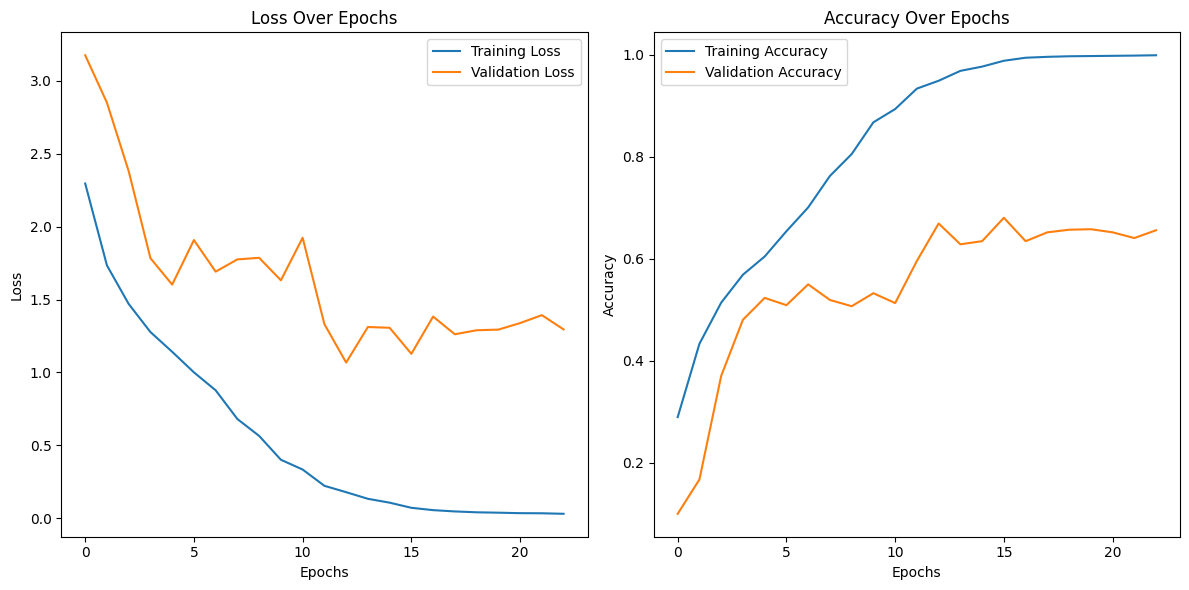

In [23]:
plot_history(history)

## 4. Evaluating the Dataset

Results indicate that model achieved 71% accuracy on test data.


In [24]:
model.evaluate(test_dataset)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7112 - loss: 0.9828


[1.119340181350708, 0.6775510311126709]

### 4.1. Actual Actual Training

71% is a good score considering all the images has background and all the othre noise. But it can be better. Hyperband does not search for all the combinations so there is a chance that a better performing model can exist out there.

Same callbacks, same 6 convolutional layers but this time first dense layer has 512 neurons and learning rate is 5e-4. For bigger dense layers 1e-3 learning rate can be better for faster learning at first then reducing. Also another opinion, 1e-3 learning rate can be better for slowly but surely gaining validation accuracy in the expense of slower train time and chance of getting stuck on local minimums. That's why 5e-4 is a good middleground.

*Changed hyperparameters are final decisions from tests conducted with different model architectures in other notebooks.*

In [59]:
# Train Callbacks reset
checkpoint_name = "Epoch{epoch:03d}-ValLoss{val_loss:.4f}-ValAcc{val_accuracy:.4f}.keras"

train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True     # saves the best weights according to monitored metric
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_weights_only=False
    ),
    tf.keras.callbacks.CSVLogger(f"model_hist_{DATE}.csv")
]

# Creating model
model = tf.keras.models.Sequential(name="super_awesome_animal_classifier")

model.add(tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

hp_conv_layer_count = 6
for i in range(hp_conv_layer_count):
    model.add(tf.keras.layers.Conv2D(int(32 * (2**i)), (3,3), padding='same', activation=None))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

# Pooling instead of flattening the output for better generalization
model.add(tf.keras.layers.GlobalAveragePooling2D())

# Dense layers
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(NUM_CLASS, activation="softmax", name="output"))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=train_callbacks
    )

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2526 - loss: 2.6597
Epoch 1: val_loss improved from inf to 2.65666, saving model to Epoch001-ValLoss2.6567-ValAcc0.1133.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.2529 - loss: 2.6576 - val_accuracy: 0.1133 - val_loss: 2.6567 - learning_rate: 5.0000e-04
Epoch 2/50
141/142 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4117 - loss: 1.7793
Epoch 2: val_loss improved from 2.65666 to 2.65113, saving model to Epoch002-ValLoss2.6511-ValAcc0.1592.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4119 - loss: 1.7783 - val_accuracy: 0.1592 - val_loss: 2.6511 - learning_rate: 5.0000e-04
Epoch 3/50
141/142 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4934 - loss: 1.5080
Epoch 3: val_loss improved from 2.65113 to 2.40467, saving model to Epoch003-ValLoss2.4047-ValAcc0.3020.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4938 - loss: 1.5071 - val_accuracy: 0.3020 - val_loss: 2.4047 -

With slight modifications validation accuracy increased to 77%.

In [60]:
model.evaluate(test_dataset)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.7763 - loss: 0.8189


[0.9608787298202515, 0.7275510430335999]

## 5. Manipulating the Test Dataset

### 5.1. Manipulation Functions

by Diclehan and Oğuzhan Ulucan.

- `get_manipulated_images(image)` function signature changed to `get_manipulated_images(image, label)` in order to save images with their labels as parent folders. According to that, saving is also changed a little.
- `get_wb_images(image)` function signature changed to `get_wb_images(image, label, file_name)` for saving white balanced version of the same image to different path with more metadata.

In [140]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Global AI Image Processing Bootcamp
Dec 2024
Diclehan and Oguzhan Ulucan
"""

# import numpy as np
# import cv2


### Fundamental functions
def linearize_image(image):
    """
    Converts an sRGB image to linear RGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.04045,
                    image / 12.92,
                    ((image + 0.055) / 1.055) ** 2.4)


def linear_to_srgb(image):
    """
    Converts a linear RGB image to sRGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.0031308,
                    image * 12.92,
                    1.055 * (image ** (1 / 2.4)) - 0.055)


def handle_saturation(image, lower=0.05, upper=0.95):
    """
    Creates a mask for non-saturated pixels (those between `lower` and `upper` thresholds)
    """
    return np.all((image > lower) & (image < upper), axis=-1)



### Color constancy
def estimate_light_source_grey_world(image, mask):
    """
    Estimates the light source based on the Grey World assumption, using valid pixels from the mask
    """
    valid_pixels = image[mask]
    avg_color = np.mean(valid_pixels, axis=0)
    return avg_color / np.linalg.norm(avg_color)


def correct_colors(image, light_source):
    """
    Corrects the colors of the image by applying white balance using the estimated light source
    """
    return image * (1.0 / light_source)


def manipulate_light_source(image, light_color):
    """
    Simulates color manipulation under a different light source

    Args:
    - image: The input image (sRGB, [0, 1])
    - light_color: The light source color (unit norm RGB vector)

    Returns:
    - Manipulated image (sRGB, [0, 1])
    """
    # Step 1: Linearize the image
    linear_image = linearize_image(image)

    # Step 2: Apply the light source (multiplying the linear image by the light color)
    manipulated_image = linear_image * light_color

    # Step 3: Convert the manipulated image back to sRGB
    manipulated_srgb = linear_to_srgb(manipulated_image)

    return np.clip(manipulated_srgb, 0, 1) 


def process_and_white_balance(image):
    """
    Applies white balance using both the Grey World and Max RGB methods
    Returns both corrected images in sRGB format
    """
    linear_image = linearize_image(image)
    valid_mask = handle_saturation(linear_image)

    # Light source estimations
    grey_world_light = estimate_light_source_grey_world(linear_image, valid_mask)

    # Color correction using both light sources
    corrected_grey_world = correct_colors(linear_image, grey_world_light)

    # Convert back to sRGB
    srgb_grey_world = linear_to_srgb(corrected_grey_world)

    # Clip and return
    return np.clip(srgb_grey_world, 0, 1)


# Light sources for color manipulation
def get_light_sources():
    """
    Returns a set of light sources for image manipulation
    """
    purplish_light = np.array([0.82, 0.15, 0.89]) / np.linalg.norm([0.82, 0.15, 0.89])
    yellowish_light = np.array([0.96, 0.24, 0.11]) / np.linalg.norm([0.96, 0.24, 0.11])
    greenish_light = np.array([0.11, 0.98, 0.12]) / np.linalg.norm([0.11, 0.98, 0.12])
    return purplish_light, yellowish_light, greenish_light


def get_wb_images(image, label, file_name):
    """
    Process and white balance the image
    """
    
    srgb_grey_world = process_and_white_balance(image)

    # Save the white-balanced images
    save_path = f"/kaggle/working/white-balanced/{label}"
    os.makedirs(save_path, exist_ok=True)
    
    cv2.imwrite(f'{save_path}/{file_name}_white_balanced_grey_world.jpg', cv2.cvtColor((srgb_grey_world*255).astype(np.uint8), cv2.COLOR_RGB2BGR))


def get_manipulated_images(image, label):
    """
    Get manipulated images by applying color vectors
    """
    
    # Get the color vectors
    purplish_light, yellowish_light, greenish_light = get_light_sources()

    # Manipulate the images under different light sources
    manipulated_purplish = manipulate_light_source(image, purplish_light)
    manipulated_yellowish = manipulate_light_source(image, yellowish_light)
    manipulated_greenish = manipulate_light_source(image, greenish_light)

    # Save the manipulated images
    save_path = f"/kaggle/working/manipulated/{label}"
    os.makedirs(save_path, exist_ok=True)
    unique = datetime.now()
    
    cv2.imwrite(f'{save_path}/{unique}_manipulated_purplish.jpg', cv2.cvtColor((manipulated_purplish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(f'{save_path}/{unique}_manipulated_yellowish.jpg', cv2.cvtColor((manipulated_yellowish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(f'{save_path}/{unique}_manipulated_greenish.jpg', cv2.cvtColor((manipulated_greenish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    

### 5.2. Manipulating Test Dataset With Different Lights

Test dataset is a normalized and batched PrefetchDataset. Every image inside test dataset has converted to numpy array, manipulated and saved to file with predefined functions.

In [113]:
for batch_images, batch_labels in test_dataset:
    # Iterate over all images and their corresponding labels in the current batch
    for image, label in zip(batch_images, batch_labels):
        # Convert the image (TensorFlow tensor) to a NumPy array
        image_np = image.numpy()

        get_manipulated_images(image_np, label)

After saving to file, manipulated images can be read like train or test datasets.

In [114]:
manipulated_test_dataset = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/manipulated",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int",
    labels="inferred",
    color_mode="rgb",
    shuffle=True
)

Found 2940 files belonging to 10 classes.


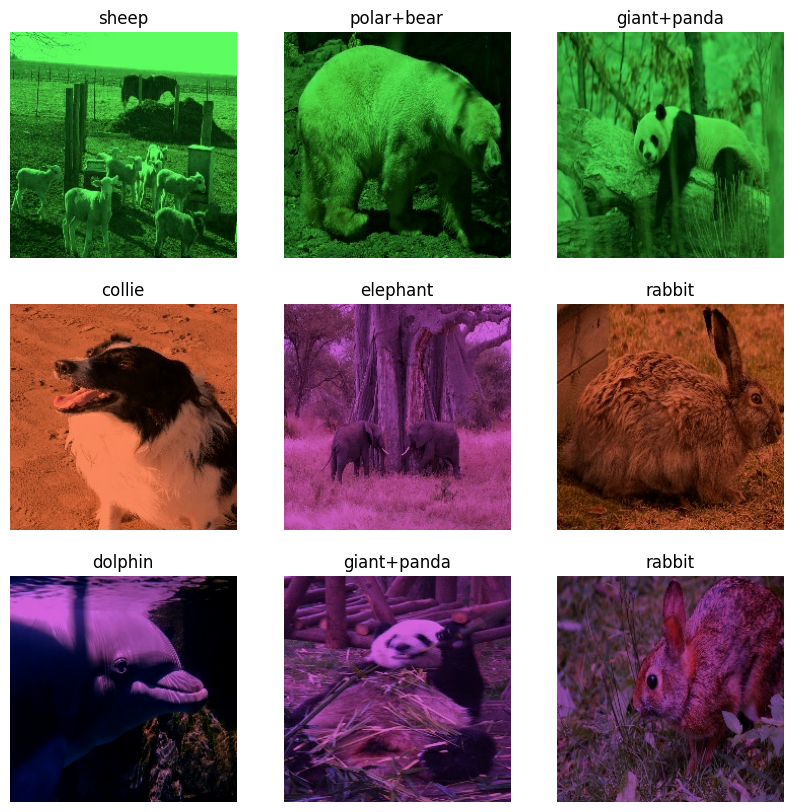

In [138]:
show_data_examples(manipulated_test_dataset)

## 6. Testing Model With Manipulated Dataset

First dataset is normalized to [0-1] with already present rescaling layer. Then evaluated as usual. Accuracy has dropped significantly. With 20% accuracy, only 10% better than random guessing.

In [139]:
manipulated_test_dataset = manipulated_test_dataset.map(lambda x, y: (normalization(x), y))
model.evaluate(manipulated_test_dataset)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2002 - loss: 4.9840


[4.950909614562988, 0.1972789168357849]

## 7. Applying Color Constancy to Manipulated Images

Manipulated images are already present in working directory. We get class names by simply reading folder names in parent directory of manipulated images. Class names are important to keep track of which image belongs to which category. For every image in class folder first being sure that file is image (just in case) then reading it with opencv. Converting image to RGB space is important. Image is normalized because predefined functions require so.

Color constancy applied images are saved with get_wb_images function.

In [142]:
base_path = "/kaggle/working/manipulated"

# Iterate over class folders (0 to 9)
for label in os.listdir(base_path):
    label_path = os.path.join(base_path, label)

    if os.path.isdir(label_path):
        print(f"Processing images in folder: {label_path}")
        
        # Iterate over each file in the class folder
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            
            # Ensure it's a file and an image
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                try:
                    # Read the image
                    image = cv2.imread(file_path, cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    if image is not None:
                        # Normalize the image
                        normalized_image = image / 255
                        
                        # Apply get_wb_images function
                        get_wb_images(normalized_image, label, file_name)
                    else:
                        print(f"Failed to read image: {file_path}")
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

Processing images in folder: /kaggle/working/manipulated/8
Processing images in folder: /kaggle/working/manipulated/6
Processing images in folder: /kaggle/working/manipulated/4
Processing images in folder: /kaggle/working/manipulated/9
Processing images in folder: /kaggle/working/manipulated/3


<ipython-input-140-e341b95e0376>:125: RuntimeWarning: invalid value encountered in cast
  cv2.imwrite(f'{save_path}/{file_name}_white_balanced_grey_world.jpg', cv2.cvtColor((srgb_grey_world*255).astype(np.uint8), cv2.COLOR_RGB2BGR))


Processing images in folder: /kaggle/working/manipulated/7
Processing images in folder: /kaggle/working/manipulated/0
Processing images in folder: /kaggle/working/manipulated/2
Processing images in folder: /kaggle/working/manipulated/5
Processing images in folder: /kaggle/working/manipulated/1


## 8. Testing Model With Color Constancy Applied Images

Same as manipulated images we read with `image_dataset_from_directory`.

Color constancy applied images look really similar. Maybe a bit brigher but in my opinion looks better than originals :D.

In [143]:
wb_dataset = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/white-balanced",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int",
    labels="inferred",
    color_mode="rgb",
    shuffle=True
)

Found 2940 files belonging to 10 classes.


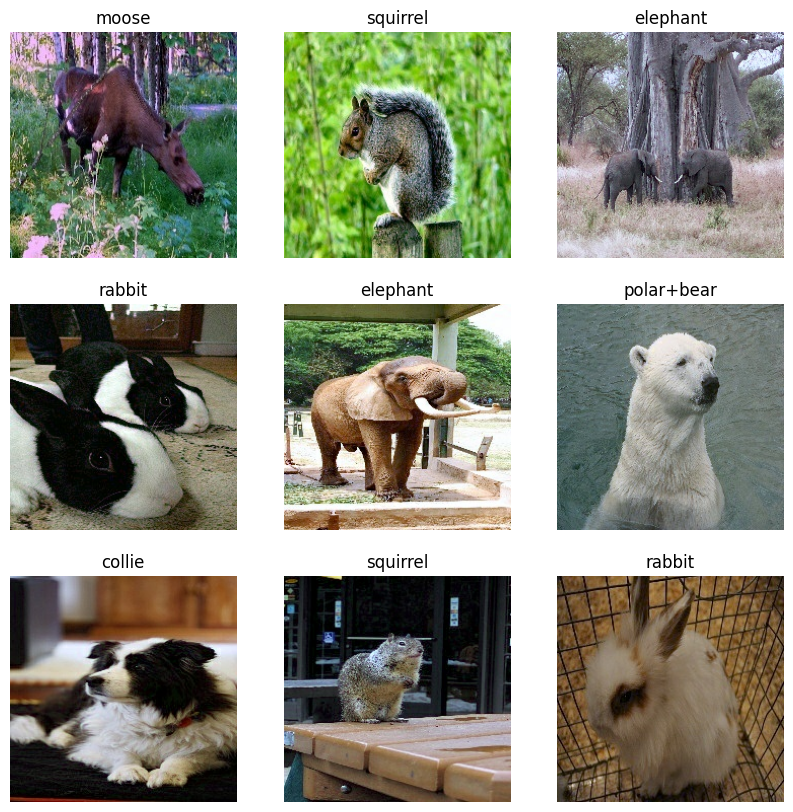

In [144]:
show_data_examples(wb_dataset)

Let's see what model thinks...

64% on white balanced images converted from colored lights applied. Not perfect considering model performs 77% accuracy on original test dataset but far better than dataset with colored lights.

In [145]:
wb_dataset = wb_dataset.map(lambda x, y: (normalization(x), y))
model.evaluate(wb_dataset)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6429 - loss: 1.2333


[1.2842961549758911, 0.6363945603370667]

## 9. Comparison of Accuracies and Finale

### Model Performance Table

| **Scenario**                               | **Accuracy** |
|--------------------------------------------|--------------|
| Hyperband tuner search model               | 57.45%       |
| Hyperband tuner trained model              | 71.12%       |
| Hand-tuned model                           | 77.63%       |
| Manipulated with colored lights            | 20.02%       |
| Accuracy after reverted colors             | 64.29%       |

This project involved training a custom CNN model on a well-prepared dataset with 10 balanced classes, augmented and normalized for optimal learning. After using Keras Tuner for hyperparameter optimization, the model's performance was slightly improved through manual fine-tuning. To evaluate robustness, test images were manipulated with colored lighting like purple, yellow and  green, resulting in a significant performance drop to 20% accuracy. Applying the Gray World algorithm to reverse the lighting effects restored accuracy to 64.29%, only 13% below the original test accuracy. Given this result, the model demonstrates reasonable robustness, but further improvements can be made. Such as enhancing lighting augmentation like data under different lights and shadows to mitigate the impact of lighting variations, preprocessing techniques like adding noise or blur (especially Gaussian Blur can enhance finding edges) or architectural adjustments like using pretrained networks or attention mechanisms for focusing more on animals rather than learning background noise.